# 같은 각도 같은 방향을 바라보고 있으면 깔끔하게 정합이 가능
1. rotate, flip, mirroring 순서를 어떻게 정할지에 대한 생각 해보기

In [49]:
import numpy as np
import cv2
import os
from utils.utils import *
import matplotlib.pyplot as plt
import numpy as np

data_dir = './result/'

imgs_list = []
for data in os.listdir(data_dir):
    if data[-4:] == ".jpg":
        img = cv2.imread(data_dir + data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs_list.append(img)


def image_stitch(imgs1, imgs2):
    imgs = [imgs1, imgs2]
    stitcher = cv2.Stitcher_create()
    status, dst = stitcher.stitch(imgs)

    return status, dst


def find_direction(img1, img2):
    # SIFT 추출기 생성
    sift = cv2.SIFT_create()

    # ORB 추출기 생성
    # orb = cv2.ORB_create()

    # 특징점과 디스크립터 추출
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 매처 생성
    flann = cv2.FlannBasedMatcher({'algorithm': 0, 'trees': 5}, {'checks': 50})

    # 매칭 결과 추출
    matches = flann.knnMatch(des1, des2, k=2)

    # 좋은 매칭 결과 필터링
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    print("good matching len : ", len(good_matches))

    # 매칭된 특징점의 위치 추출
    points1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
    points2 = np.array([kp2[m.trainIdx].pt for m in good_matches])

    # 호모그래피 계산
    H, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # 회전 각도 계산
    angle = np.rad2deg(np.arctan2(H[1, 0], H[0, 0]))

    return angle
    
    



In [50]:
def collect(imgs1, imgs2, angle):
    while True:
        if angle <= 5 and angle >= -5: # 같은 방향을 보고 있을 때
            break

        elif angle <= 95 and angle >= 85: # 90도 방향 차이
            imgs2 = rotate(imgs2)
            angle = find_direction(imgs1, imgs2)
        
        elif angle <= -85 and angle >= -95: # -90도 방향 차이
            imgs2 = rotate(mirroring(imgs2))
            angle = find_direction(imgs1, imgs2)
            
        elif angle <= 185 and angle >= 175: # 180도 방향차이
            imgs2 = mirroring(imgs2)
            angle = find_direction(imgs1, imgs2)

        elif angle <= -175 and angle >= -185: # -180도 방향 차이
            imgs2 = flip(mirroring(imgs2))
            angle = find_direction(imgs1, imgs2)
        
        else:
            return imgs1, imgs2, False
            
    return imgs1, imgs2, True
        


In [51]:
angle = find_direction(imgs_list[0], imgs_list[1])
print(angle)

good matching len :  680
89.99432842247202


In [52]:
imgs1, imgs2, no_degree = collect(imgs_list[0], imgs_list[1], angle)
no_degree

good matching len :  738


True

In [53]:
def merge_image(imgs1, imgs2, status):
    status, img_stitch = image_stitch(imgs1, imgs2)
    if status == 1:
        status, img_stitch = image_stitch(imgs1, flip(imgs2))

    return status, img_stitch

In [58]:
def total_merge(imgs_list):
    latest = []
    status = 0
    for i, k in enumerate(imgs_list):
        if i == 0:
            imgs1 = k
            continue

        imgs2 = k
        angle = find_direction(imgs1, imgs2)
        print(f"imgs1, imgs2의 angle은 {angle}이다.")
        imgs1, imgs2, no_degree = collect(imgs1, imgs2, angle)
        
        if no_degree == False:
            latest.append(imgs2)
            print(f"{i+1}번째 이미지 리스트에 추가")
        else:
            status, img_stitch = merge_image(imgs1, imgs2, status)
            if status == 0:
                imgs1 = img_stitch
                plt.imshow(imgs1)
                print(f"{i+1}번째 이미지 완료")
            else:
                latest.append(imgs2)
            
    return imgs1, latest


good matching len :  680
imgs1, imgs2의 angle은 89.99432842247202이다.
good matching len :  738
2번째 이미지 완료
good matching len :  210
imgs1, imgs2의 angle은 89.77792630849785이다.
good matching len :  216
good matching len :  25
imgs1, imgs2의 angle은 -179.9858139355489이다.
good matching len :  32
4번째 이미지 완료
good matching len :  81
imgs1, imgs2의 angle은 -88.36216040612629이다.
good matching len :  14
5번째 이미지 리스트에 추가
good matching len :  830
imgs1, imgs2의 angle은 179.42226911267002이다.
good matching len :  61
6번째 이미지 완료
good matching len :  244
imgs1, imgs2의 angle은 179.89383045608142이다.
good matching len :  34
7번째 이미지 리스트에 추가
good matching len :  33
imgs1, imgs2의 angle은 -178.9565646561601이다.
good matching len :  41
8번째 이미지 완료
good matching len :  541
imgs1, imgs2의 angle은 89.98802045310735이다.
good matching len :  568
9번째 이미지 완료
good matching len :  122
imgs1, imgs2의 angle은 0.4236369010122379이다.
good matching len :  37
imgs1, imgs2의 angle은 -97.80588648658906이다.
3번째 이미지 리스트에 추가
good matching len :  42
imgs1

KeyboardInterrupt: 

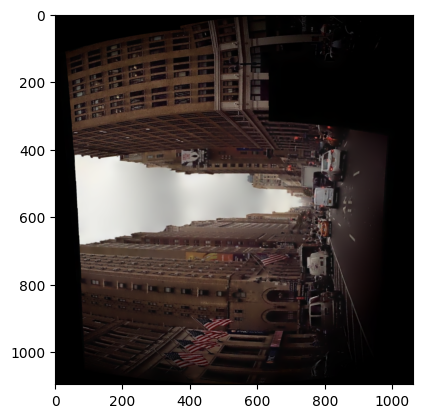

In [66]:
imgs1, latest = total_merge(imgs_list)

if len(latest) == 0:
    plt.imshow(imgs1)

count = 0
while len(latest) != 0:
    count += 1
    latest.insert(0, imgs1)
    imgs1, latest = total_merge(latest)
    cv2.imwrite(f"./final/imgs{count}.jpg", cv2.cvtColor(imgs1, cv2.COLOR_BGR2RGB))
    print(f"남은 이미지의 개수는 {len(latest)}")

plt.imshow(imgs1)

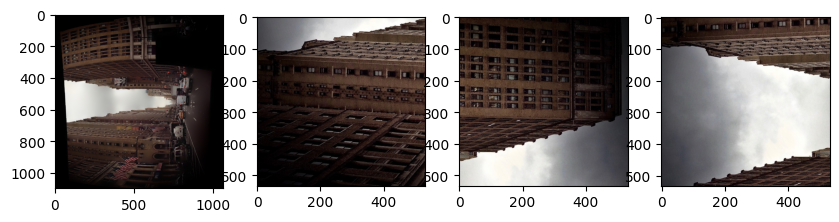

In [69]:
visualize(latest)